In [25]:
from datetime import datetime

author = "johan-yapo"
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Create the author and timestamp markdown content
markdown_content = f"""
# Author and Timestamp Information

- **Author**: {author}
- **Date**: {timestamp}
"""

# Display the markdown content
from IPython.display import display, Markdown
display(Markdown(markdown_content))


# Author and Timestamp Information

- **Author**: johan-yapo
- **Date**: 2025-03-28 20:45:34


## Imports

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from CBFV import composition
from time import time
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
#formula group needs to be integers
from sklearn.preprocessing import OrdinalEncoder
from matplotlib.patches import Patch
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import pickle

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

In [27]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

## Collection

In [28]:
df_train = pd.read_csv(DATA_PATH + "/intermetallics_train7.csv")
df_val = pd.read_csv(DATA_PATH + "/intermetallics_val7.csv")
df_test = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")
df_test_og = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")

## Preprocessing

In [29]:
df_train = df_train.drop_duplicates()
df_val = df_val.drop_duplicates()
df_test = df_test.drop_duplicates()
df_test_og = df_test_og.drop_duplicates()

In [30]:
df_train.drop(columns=['composition', 'material_id',
              'structure'], axis=1, inplace=True)

df_val.drop(columns=['composition', 'material_id',
            'structure'], axis=1, inplace=True)

df_test.drop(columns=['composition', 'material_id',
             'structure'], axis=1, inplace=True)

df_train.drop(['total_magnetization',
              'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_val.drop(['total_magnetization',
            'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_test.drop(['total_magnetization',
             'total_magnetization_normalized_vol'], axis=1, inplace=True)

df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5197, 1594)
df_val DataFrame shape: (1504, 1594)
df_test DataFrame shape: (747, 1594)


In [31]:
#Need to rename formula_pretty column to formula and total_magnetization_formula_units to target since CBFV needs that 
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns=X_train_unscaled.columns.values.tolist()

Processing Input Data: 100%|██████████| 5197/5197 [00:00<00:00, 10509.12it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5197/5197 [00:00<00:00, 5976.21it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1504/1504 [00:00<00:00, 16333.31it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1504/1504 [00:00<00:00, 10325.71it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 747/747 [00:00<00:00, 14682.37it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 747/747 [00:00<00:00, 9572.61it/s]


	Creating Pandas Objects...


In [35]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(6701, 1746)


In [36]:
enc = OrdinalEncoder()

df_train_new = pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula", "number"]])
df_train_new[["formula", "number"]] = enc.transform(
    df_train_new[["formula", "number"]])

groups = df_train_new['formula']
gkf = GroupKFold(n_splits = 5)

## Data Visualizations

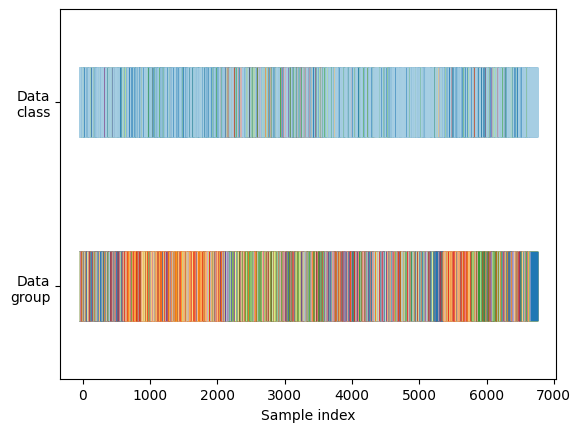

In [39]:
#Visualize data for CV
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


data_vis = visualize_groups(y_train_new, groups, "no groups")



In [40]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=5):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

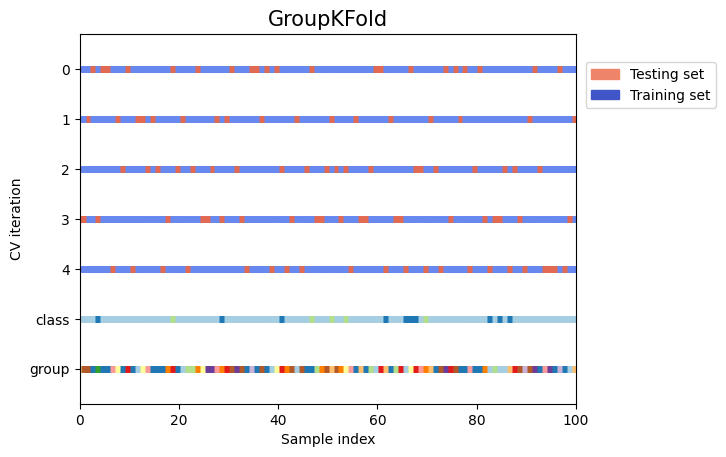

In [ ]:
fig, ax = plt.subplots()
cv = GroupKFold(n_splits=5)
cv_plot = plot_cv_indices(gkf, df_train_new, y_train_new, groups, ax, 5)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)

##cv_plot.figure.savefig('C:/Users/joeya/Documents/Fokwa Group/ML_tutorial/intermetallics/plots/classic_models/jarvis/cv_plot2_{}_transparent.png', 
    ##bbox_inches='tight', dpi=600, transparent = True)
##cv_plot.figure.savefig('C:/Users/joeya/Documents/Fokwa Group/ML_tutorial/intermetallics/plots/classic_models/jarvis/cv_plot2_{}_.png', 
    ##bbox_inches='tight', dpi=600)